In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import time
import os,jpype
import json_lines
from tqdm import tqdm
import seaborn as sns
import Levenshtein
import random

In [2]:
trainset_0=pd.read_csv("AnalysticalData/java_code_trainset_0_count.csv")  
total_trainset=pd.DataFrame(columns=list(trainset_0.columns))
for x in range(0,16,1):
    c_trainset=pd.read_csv("AnalysticalData/java_code_trainset_"+str(x)+"_count.csv")  
    total_trainset=pd.concat([total_trainset, c_trainset], ignore_index=True) 

In [3]:
valuation =pd.read_csv("AnalysticalData/java_code_valset_count.csv")  
valuation=valuation.drop(['Unnamed: 0'], axis=1)
valuation["Complexity"] = valuation["Complexity"].astype(int)
valuation["LineNumber"] = valuation["LineNumber"].astype(int)
valuation["Methodlength"] =valuation["Methodlength"].astype(int)
valuation["LLratio"] = valuation["LLratio"].astype(float)
valuation["StringPercentage"] =valuation["StringPercentage"].astype(float)
valuation .head(5)

Original  \
0  @Override\n  public final String escape(String...   
1  @Override\n  protected final char[] escape(int...   
2  @Override\n  protected final int nextEscapeInd...   
3  public BufferedReader openBufferedStream() thr...   
4  @Beta\n  public long length() throws IOExcepti...   

                                              Parsed  \
0  @Override public final String escape(String s)...   
1  @Override protected final char[] escape(int cp...   
2  @Override protected final int nextEscapeIndex(...   
3  public BufferedReader openBufferedStream() thr...   
4  @Beta public long length() throws IOException ...   

                                               Fixed  \
0  @Override public final String escape(String s)...   
1  @Override protected final char[] escape(int cp...   
2  @Override protected final int nextEscapeIndex(...   
3  public BufferedReader openBufferedStream() thr...   
4  @Beta public long length() throws IOException ...   

                                               Train  \
0  @Override public final String escape(String s)...   
1  @Override protected final char[] escape(int cp...   
2  @Override protected final int nextEscapeIndex(...   
3  public BufferedReader openBufferedStream() thr...   
4  @Beta public long length() throws IOException ...   

                                           Train-OPT  Complexity  LineNumber  \
0  @Override public final String escape(String s)...           6          10   
1  @Override protected final char[] escape(int cp...           5          12   
2  @Override protected final int nextEscapeIndex(...           6          10   
3  public BufferedReader openBufferedStream() thr...           2           4   
4  @Beta public long length() throws IOException ...           2          17   

   Methodlength    LLratio  StringPercentage  \
0           304  30.400000               0.0   
1           285  23.750000               0.0   
2           315  31.500000               0.0   
3           200  50.000000               0.0   
4           421  24.764706               0.0   

                                               Input  \
0  @Override public final String escape(String s)...   
1  @Override protected final char[] escape(int cp...   
2  @Override protected final int nextEscapeIndex(...   
3  public BufferedReader openBufferedStream() thr...   
4  @Beta public long length() throws IOException ...   

                                              Output  
0                                        return s;\n  
1                   char[] chars=replacements[cp];\n  
2      if ((c < replacementsLength && replacement...  
3                      Reader reader=openStream();\n  
4                  return countBySkipping(reader);\n

In [6]:
#Train /  Test
test=pd.read_csv("AnalysticalData/java_code_testset_count.csv")  
test=test.drop(['Unnamed: 0'], axis=1)
test["Complexity"] = test["Complexity"].astype(int)
test["LineNumber"] = test["LineNumber"].astype(int)
test["Methodlength"] =test["Methodlength"].astype(int)
test["LLratio"] = test["LLratio"].astype(float)
test["StringPercentage"] =test["StringPercentage"].astype(float)
test .head(5)

Original  \
0  protected final void fastPathOrderedEmit(U val...   
1  @CheckReturnValue\n    @NonNull\n    @Schedule...   
2  @SuppressWarnings("unchecked")\n    @CheckRetu...   
3  @SuppressWarnings({ "unchecked", "rawtypes" })...   
4  @SuppressWarnings({ "unchecked", "rawtypes" })...   

                                              Parsed  \
0  protected final void fastPathOrderedEmit(U val...   
1  @CheckReturnValue @NonNull @SchedulerSupport(S...   
2  @SuppressWarnings("unchecked") @CheckReturnVal...   
3  @SuppressWarnings({"unchecked","rawtypes"}) @C...   
4  @SuppressWarnings({"unchecked","rawtypes"}) @C...   

                                               Fixed  \
0  protected final void fastPathOrderedEmit(U val...   
1  @CheckReturnValue @NonNull @SchedulerSupport(S...   
2  @SuppressWarnings("unchecked") @CheckReturnVal...   
3  @SuppressWarnings({"unchecked","rawtypes"}) @C...   
4  @SuppressWarnings({"unchecked","rawtypes"}) @C...   

                                               Train  \
0  protected final void fastPathOrderedEmit(U val...   
1  @CheckReturnValue @NonNull @SchedulerSupport(S...   
2  @SuppressWarnings("unchecked") @CheckReturnVal...   
3  @SuppressWarnings({"unchecked","rawtypes"}) @C...   
4  @SuppressWarnings({"unchecked","rawtypes"}) @C...   

                                           Train-OPT  Complexity  LineNumber  \
0  protected final void fastPathOrderedEmit(U val...           6          22   
1  @CheckReturnValue @NonNull @SchedulerSupport(S...           1           4   
2  @SuppressWarnings("unchecked") @CheckReturnVal...           3          11   
3  @SuppressWarnings({"unchecked","rawtypes"}) @C...           1           4   
4  @SuppressWarnings({"unchecked","rawtypes"}) @C...           1           5   

   Methodlength    LLratio  StringPercentage  \
0           565  25.681818          0.000000   
1           301  75.250000          0.049834   
2           468  42.545455          0.051282   
3           380  95.000000          0.084211   
4           473  94.600000          0.084567   

                                               Input  \
0  protected final void fastPathOrderedEmit(U val...   
1  @CheckReturnValue @NonNull @SchedulerSupport(S...   
2  @SuppressWarnings("unchecked") @CheckReturnVal...   
3  @SuppressWarnings({"unchecked","rawtypes"}) @C...   
4  @SuppressWarnings({"unchecked","rawtypes"}) @C...   

                                              Output  
0                          accept(observer,value);\n  
1    return RxJavaPlugins.onAssembly(new Observab...  
2                                  if (len == 1) {\n  
3    ObjectHelper.requireNonNull(sources,"sources...  
4    ObjectHelper.requireNonNull(sources,"sources...

In [8]:
total_trainset=total_trainset.drop(['Unnamed: 0'], axis=1)
total_trainset["Complexity"] = total_trainset["Complexity"].astype(int)
total_trainset["LineNumber"] = total_trainset["LineNumber"].astype(int)
total_trainset["Methodlength"] = total_trainset["Methodlength"].astype(int)
total_trainset["LLratio"] = total_trainset["LLratio"].astype(float)
total_trainset["StringPercentage"] = total_trainset["StringPercentage"].astype(float)
total_trainset.head()

Original  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(\n\t\t...   
2  public void addServletRegistrationBeans(\n\t\t...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                              Parsed  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                               Fixed  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                               Train  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                           Train-OPT  Complexity  LineNumber  \
0  protected final void bindIndexed(Configuration...           4           8   
1  public void setServletRegistrationBeans(Collec...           1           4   
2  public void addServletRegistrationBeans(Servle...           1           4   
3  public void setServletNames(Collection<String>...           1           4   
4  public void addServletNames(String... servletN...           1           4   

   Methodlength  LLratio  StringPercentage  \
0           479   59.875          0.000000   
1           292   73.000          0.140411   
2           272   68.000          0.150735   
3           190   47.500          0.152632   
4           183   45.750          0.158470   

                                               Input  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                              Output  
0    for (  ConfigurationPropertySource source : ...  
1    this.servletRegistrationBeans=new LinkedHash...  
2    Collections.addAll(this.servletRegistrationB...  
3    this.servletNames=new LinkedHashSet<>(servle...  
4    this.servletNames.addAll(Arrays.asList(servl...

In [9]:
len(total_trainset)

454451

In [10]:
alits= [x.startswith("Parser Error:") for x in total_trainset["Parsed"]]
total_trainset_pf=total_trainset[alits]
len(total_trainset_pf)

503

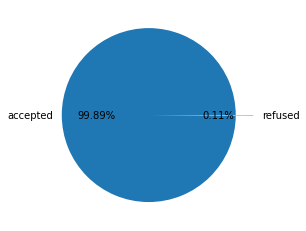

In [11]:
y = np.array([453948,503])

plt.pie(y,labels=['accepted','refused'],explode=(0, 0.2,), autopct='%.2f%%',)
plt.show()

In [12]:
total_trainset.head()

Original  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(\n\t\t...   
2  public void addServletRegistrationBeans(\n\t\t...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                              Parsed  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                               Fixed  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                               Train  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                           Train-OPT  Complexity  LineNumber  \
0  protected final void bindIndexed(Configuration...           4           8   
1  public void setServletRegistrationBeans(Collec...           1           4   
2  public void addServletRegistrationBeans(Servle...           1           4   
3  public void setServletNames(Collection<String>...           1           4   
4  public void addServletNames(String... servletN...           1           4   

   Methodlength  LLratio  StringPercentage  \
0           479   59.875          0.000000   
1           292   73.000          0.140411   
2           272   68.000          0.150735   
3           190   47.500          0.152632   
4           183   45.750          0.158470   

                                               Input  \
0  protected final void bindIndexed(Configuration...   
1  public void setServletRegistrationBeans(Collec...   
2  public void addServletRegistrationBeans(Servle...   
3  public void setServletNames(Collection<String>...   
4  public void addServletNames(String... servletN...   

                                              Output  
0    for (  ConfigurationPropertySource source : ...  
1    this.servletRegistrationBeans=new LinkedHash...  
2    Collections.addAll(this.servletRegistrationB...  
3    this.servletNames=new LinkedHashSet<>(servle...  
4    this.servletNames.addAll(Arrays.asList(servl...

# Code that cannot be accepted by parser

In [13]:
print(total_trainset_pf["Original"][2703])

public void writeToStream(OutputStream out, byte[] writeBuffer) throws IOException {
    if (baseObject instanceof byte[]) {
      int offsetInByteArray = (int) (baseOffset - Platform.BYTE_ARRAY_OFFSET);
      out.write((byte[]) baseObject, offsetInByteArray, sizeInBytes);
    }


In [14]:
len(total_trainset)-len(total_trainset_pf)

453948

In [15]:
alits= [x.startswith("Fix failed") for x in total_trainset["Fixed"]]
total_trainset_ff=total_trainset[alits]
len(total_trainset_ff)

141

In [16]:
len(total_trainset)-len(total_trainset_ff)

454310

# Performance of DataAnalystictool to repair codes

In [33]:
#parsed failed
len(total_trainset_pf)

503

In [34]:
#Repair succeeded
len(total_trainset_ff)

141

In [35]:
(len(total_trainset_pf)- len(total_trainset_ff))

362

In [36]:
#Repair succeeded percentage
(len(total_trainset_pf)- len(total_trainset_ff)) / len(total_trainset_pf)

0.7196819085487077

# Rate of code that can be accepted by the parser before repair

In [37]:
round((len(total_trainset)-len(total_trainset_pf))/len(total_trainset),4)

0.9989

# Rate of code that can be accepted by the parser after repair

In [38]:
round( (len(total_trainset)-  len(total_trainset_ff)) /len(total_trainset),4)

0.9997

# Exploratory data analysis

In [39]:
# Fixed
total_trainset_p=total_trainset[total_trainset["Methodlength"]>0]
len(total_trainset_p)

454310

In [40]:
total_trainset_p.describe()

Complexity     LineNumber   Methodlength        LLratio  \
count  454310.000000  454310.000000  454310.000000  454310.000000   
mean        3.586221      13.661196     569.301336      45.807820   
std        12.997396      25.861618    1202.752702      36.602309   
min         1.000000       2.000000      66.000000       7.552356   
25%         1.000000       5.000000     217.000000      33.032258   
50%         2.000000       9.000000     341.000000      41.625000   
75%         4.000000      15.000000     615.000000      53.000000   
max      4435.000000    7706.000000  407163.000000   13276.750000   

       StringPercentage  
count     454310.000000  
mean           0.032846  
std            0.061352  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.044693  
max            0.910124

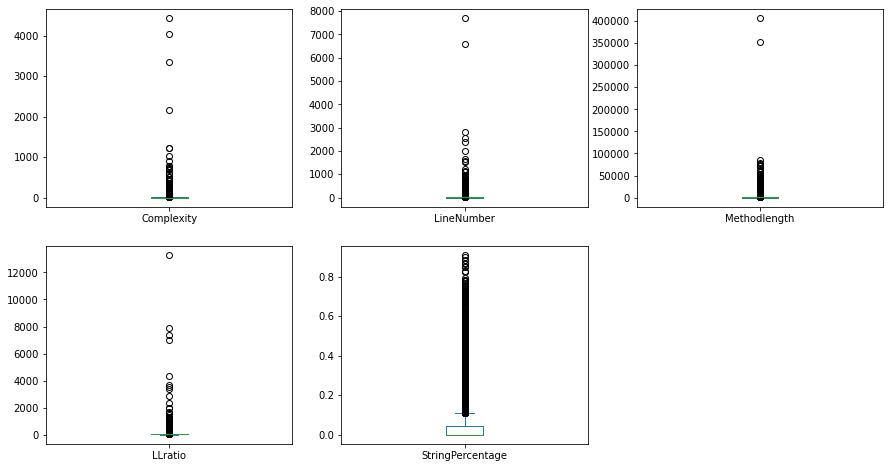

In [41]:
total_trainset_p.plot(kind='box',figsize=(15,8), subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

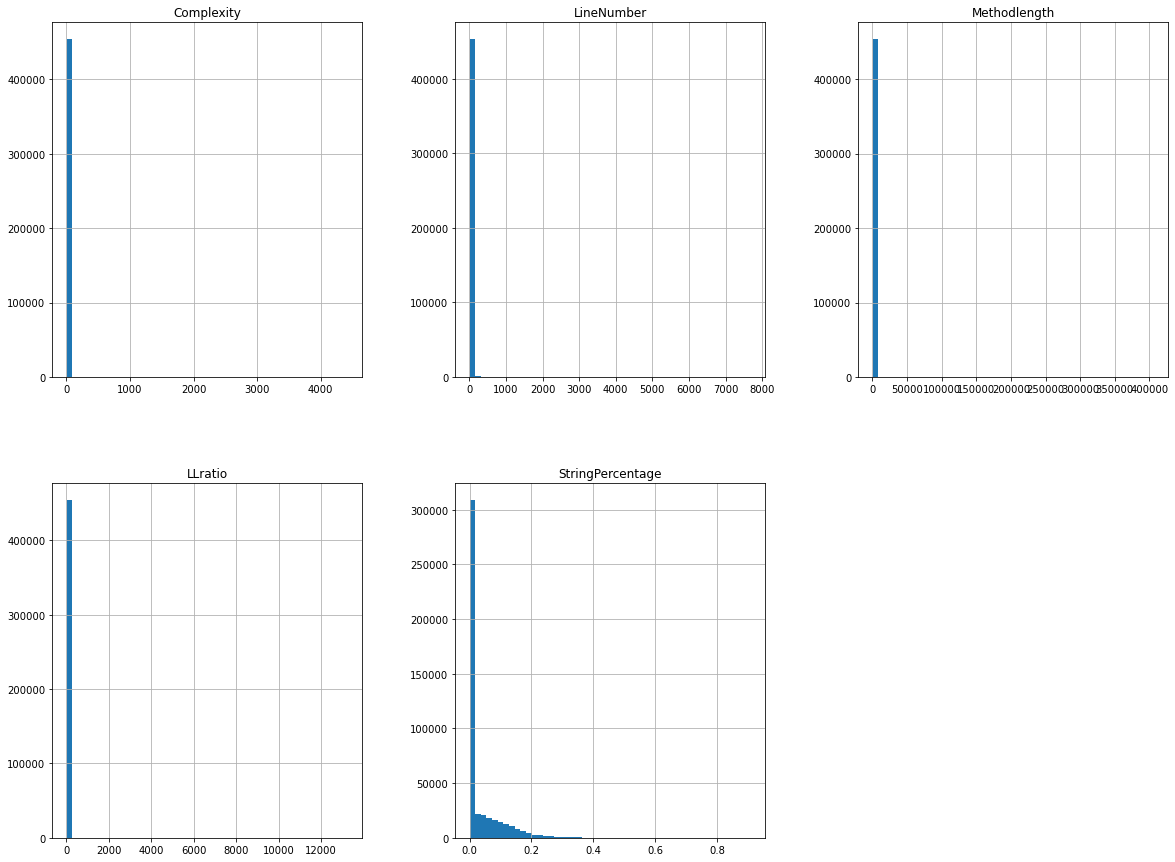

In [42]:
total_trainset_p.hist(bins=50,figsize=(20,15),layout=(2,3))
plt.show()

# Code with an outlier value
complexity	lineNumber	methodlength	LLratio	StringPercentage

In [43]:
total_trainset_p["Complexity"].max()

4435

In [44]:
total_trainset_p[total_trainset_p["Complexity"]>=2000]

Original  \
35753  public final void mID() throws RecognitionExce...   
36438  @Override\n\tpublic void mTokens() throws Reco...   
45807  @Override\r\n\tprotected T doSwitch(int classi...   
47654  @Override\r\n\tprotected T doSwitch(int classi...   

                                                  Parsed  \
35753  public final void mID() throws RecognitionExce...   
36438  @Override public void mTokens() throws Recogni...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                   Fixed  \
35753  public final void mID() throws RecognitionExce...   
36438  @Override public void mTokens() throws Recogni...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                   Train  \
35753  public final void mID() throws RecognitionExce...   
36438  @Override public void mTokens() throws Recogni...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                               Train-OPT  Complexity  \
35753  public final void mID() throws RecognitionExce...        3353   
36438  @Override public void mTokens() throws Recogni...        2157   
45807  @Override protected T doSwitch(int classifierI...        4029   
47654  @Override protected T doSwitch(int classifierI...        4435   

       LineNumber  Methodlength     LLratio  StringPercentage  \
35753          97         85325  879.639175               0.0   
36438         114         48894  428.894737               0.0   
45807        6591        353202   53.588530               0.0   
47654        7706        407163   52.837140               0.0   

                                                   Input  \
35753  public final void mID() throws RecognitionExce...   
36438  @Override public void mTokens() throws Recogni...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                  Output  
35753                    if (state.backtracking > 0) {\n  
36438                        if (state.failed) return;\n  
45807             case Ifc4Package.IFC_WORK_SCHEDULE:{\n  
47654  if (result == null) result=caseIfcObjectDefini...

In [45]:
print(total_trainset_p["Fixed"][35753])

public final void mID() throws RecognitionException {
  try {
    int _type=ID;
    int _channel=DEFAULT_TOKEN_CHANNEL;
    int alt62=2;
    int LA62_0=input.LA(1);
    if ((LA62_0 == '$' || (LA62_0 >= 'A' && LA62_0 <= 'Z') || LA62_0 == '_' || (LA62_0 >= 'a' && LA62_0 <= 'z') || (LA62_0 >= '\u00A2' && LA62_0 <= '\u00A5') || LA62_0 == '\u00AA' || LA62_0 == '\u00B5' || LA62_0 == '\u00BA' || (LA62_0 >= '\u00C0' && LA62_0 <= '\u00D6') || (LA62_0 >= '\u00D8' && LA62_0 <= '\u00F6') || (LA62_0 >= '\u00F8' && LA62_0 <= '\u0236') || (LA62_0 >= '\u0250' && LA62_0 <= '\u02C1') || (LA62_0 >= '\u02C6' && LA62_0 <= '\u02D1') || (LA62_0 >= '\u02E0' && LA62_0 <= '\u02E4') || LA62_0 == '\u02EE' || LA62_0 == '\u037A' || LA62_0 == '\u0386' || (LA62_0 >= '\u0388' && LA62_0 <= '\u038A') || LA62_0 == '\u038C' || (LA62_0 >= '\u038E' && LA62_0 <= '\u03A1') || (LA62_0 >= '\u03A3' && LA62_0 <= '\u03CE') || (LA62_0 >= '\u03D0' && LA62_0 <= '\u03F5') || (LA62_0 >= '\u03F7' && LA62_0 <= '\u03FB') || (LA62_0 >= '\u

In [46]:
total_trainset_p["LineNumber"].max()

7706

In [47]:
total_trainset_p[total_trainset_p["LineNumber"]>=2000]

Original  \
45807   @Override\r\n\tprotected T doSwitch(int classi...   
47654   @Override\r\n\tprotected T doSwitch(int classi...   
147230  public final EObject ruleType() throws Recogni...   
147236  public final EObject ruleAOPMember() throws Re...   
147238  public final EObject ruleMember() throws Recog...   
393409  @Override\n\tprotected T doSwitch(int classifi...   

                                                   Parsed  \
45807   @Override protected T doSwitch(int classifierI...   
47654   @Override protected T doSwitch(int classifierI...   
147230  public final EObject ruleType() throws Recogni...   
147236  public final EObject ruleAOPMember() throws Re...   
147238  public final EObject ruleMember() throws Recog...   
393409  @Override protected T doSwitch(int classifierI...   

                                                    Fixed  \
45807   @Override protected T doSwitch(int classifierI...   
47654   @Override protected T doSwitch(int classifierI...   
147230  public final EObject ruleType() throws Recogni...   
147236  public final EObject ruleAOPMember() throws Re...   
147238  public final EObject ruleMember() throws Recog...   
393409  @Override protected T doSwitch(int classifierI...   

                                                    Train  \
45807   @Override protected T doSwitch(int classifierI...   
47654   @Override protected T doSwitch(int classifierI...   
147230  public final EObject ruleType() throws Recogni...   
147236  public final EObject ruleAOPMember() throws Re...   
147238  public final EObject ruleMember() throws Recog...   
393409  @Override protected T doSwitch(int classifierI...   

                                                Train-OPT  Complexity  \
45807   @Override protected T doSwitch(int classifierI...        4029   
47654   @Override protected T doSwitch(int classifierI...        4435   
147230  public final EObject ruleType() throws Recogni...         590   
147236  public final EObject ruleAOPMember() throws Re...         742   
147238  public final EObject ruleMember() throws Recog...         676   
393409  @Override protected T doSwitch(int classifierI...        1022   

        LineNumber  Methodlength    LLratio  StringPercentage  \
45807         6591        353202  53.588530          0.000000   
47654         7706        407163  52.837140          0.000000   
147230        2003         53989  26.954069          0.055974   
147236        2812         75193  26.740043          0.062266   
147238        2537         67563  26.631060          0.061839   
393409        2385         74534  31.251153          0.000000   

                                                    Input  \
45807   @Override protected T doSwitch(int classifierI...   
47654   @Override protected T doSwitch(int classifierI...   
147230  public final EObject ruleType() throws Recogni...   
147236  public final EObject ruleAOPMember() throws Re...   
147238  public final EObject ruleMember() throws Recog...   
393409  @Override protected T doSwitch(int classifierI...   

                                                   Output  
45807              case Ifc4Package.IFC_WORK_SCHEDULE:{\n  
47654   if (result == null) result=caseIfcObjectDefini...  
147230                   if (state.backtracking == 0) {\n  
147236                                         case 3:{\n  
147238                                    int alt173=2;\n  
393409                   T result=caseGCMRKRG(gcmrkrg);\n

In [48]:
print(total_trainset_p["Fixed"][147230])

public final EObject ruleType() throws RecognitionException {
  EObject current=null;
  Token otherlv_4=null;
  Token otherlv_6=null;
  Token otherlv_8=null;
  Token otherlv_10=null;
  Token otherlv_13=null;
  Token otherlv_15=null;
  Token otherlv_17=null;
  Token otherlv_19=null;
  Token otherlv_21=null;
  Token otherlv_24=null;
  Token otherlv_26=null;
  Token otherlv_28=null;
  Token otherlv_30=null;
  Token otherlv_33=null;
  Token otherlv_35=null;
  Token otherlv_37=null;
  Token otherlv_39=null;
  Token otherlv_42=null;
  Token otherlv_45=null;
  Token otherlv_47=null;
  Token otherlv_49=null;
  Token otherlv_51=null;
  Token otherlv_53=null;
  Token otherlv_56=null;
  Token otherlv_58=null;
  Token otherlv_59=null;
  Token otherlv_62=null;
  Token otherlv_64=null;
  Token otherlv_65=null;
  Token otherlv_68=null;
  Token otherlv_70=null;
  Token otherlv_72=null;
  Token otherlv_74=null;
  Token otherlv_76=null;
  Token otherlv_78=null;
  Token otherlv_80=null;
  Token otherlv_8

In [49]:
total_trainset_p["Methodlength"].max()

407163

In [50]:
total_trainset_p[total_trainset_p["Methodlength"]>=80000]

Original  \
35753  public final void mID() throws RecognitionExce...   
45807  @Override\r\n\tprotected T doSwitch(int classi...   
47654  @Override\r\n\tprotected T doSwitch(int classi...   

                                                  Parsed  \
35753  public final void mID() throws RecognitionExce...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                   Fixed  \
35753  public final void mID() throws RecognitionExce...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                   Train  \
35753  public final void mID() throws RecognitionExce...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                               Train-OPT  Complexity  \
35753  public final void mID() throws RecognitionExce...        3353   
45807  @Override protected T doSwitch(int classifierI...        4029   
47654  @Override protected T doSwitch(int classifierI...        4435   

       LineNumber  Methodlength     LLratio  StringPercentage  \
35753          97         85325  879.639175               0.0   
45807        6591        353202   53.588530               0.0   
47654        7706        407163   52.837140               0.0   

                                                   Input  \
35753  public final void mID() throws RecognitionExce...   
45807  @Override protected T doSwitch(int classifierI...   
47654  @Override protected T doSwitch(int classifierI...   

                                                  Output  
35753                    if (state.backtracking > 0) {\n  
45807             case Ifc4Package.IFC_WORK_SCHEDULE:{\n  
47654  if (result == null) result=caseIfcObjectDefini...

In [51]:
print(total_trainset_p["Fixed"][47654])

@Override protected T doSwitch(int classifierID,EObject theEObject){
switch (classifierID) {
case Ifc2x3tc1Package.IFC2_DCOMPOSITE_CURVE:{
      Ifc2DCompositeCurve ifc2DCompositeCurve=(Ifc2DCompositeCurve)theEObject;
      T result=caseIfc2DCompositeCurve(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcCompositeCurve(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcBoundedCurve(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcCurve(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcCurveOrEdgeCurve(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcGeometricRepresentationItem(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcGeometricSetSelect(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcRepresentationItem(ifc2DCompositeCurve);
      if (result == null)       result=caseIfcLayeredItem(ifc2DCompositeCurve);
      if (result == null)       result=defaultCa

In [52]:
total_trainset_p["LLratio"].max()

13276.75

In [53]:
total_trainset_p[total_trainset_p["LLratio"]>=13276.75]

Original  \
211566  @Override protected FieldItem[] getDefaultTask...   

                                                   Parsed  \
211566  @Override protected FieldItem[] getDefaultTask...   

                                                    Fixed  \
211566  @Override protected FieldItem[] getDefaultTask...   

                                                    Train  \
211566  @Override protected FieldItem[] getDefaultTask...   

                                                Train-OPT  Complexity  \
211566  @Override protected FieldItem[] getDefaultTask...           1   

        LineNumber  Methodlength   LLratio  StringPercentage  \
211566           4         53107  13276.75               0.0   

                                                    Input  \
211566  @Override protected FieldItem[] getDefaultTask...   

                                                   Output  
211566    FieldItem[] result=new FieldItem[]{new Field...

In [54]:
print(len(total_trainset_p["Fixed"][211566]))

53102


In [55]:
print(total_trainset_p["Fixed"][211566])

@Override protected FieldItem[] getDefaultTaskData(){
  FieldItem[] result=new FieldItem[]{new FieldItem(TaskField.UNIQUE_ID,FieldLocation.FIXED_DATA,0,0,86,0,0),new FieldItem(TaskField.ID,FieldLocation.FIXED_DATA,0,4,23,0,0),new FieldItem(TaskField.EARLY_FINISH,FieldLocation.FIXED_DATA,0,8,38,0,0),new FieldItem(TaskField.LATE_START,FieldLocation.FIXED_DATA,0,12,39,0,0),new FieldItem(TaskField.STOP,FieldLocation.FIXED_DATA,0,16,100,0,0),new FieldItem(TaskField.RESUME,FieldLocation.FIXED_DATA,0,20,99,0,0),new FieldItem(TaskField.FREE_SLACK,FieldLocation.FIXED_DATA,0,24,21,0,0),new FieldItem(TaskField.START_SLACK,FieldLocation.FIXED_DATA,0,28,438,0,0),new FieldItem(TaskField.FINISH_SLACK,FieldLocation.FIXED_DATA,0,32,439,0,0),new FieldItem(TaskField.PARENT_TASK_UNIQUE_ID,FieldLocation.FIXED_DATA,0,36,160,0,0),new FieldItem(TaskField.OUTLINE_LEVEL,FieldLocation.FIXED_DATA,0,40,249,0,0),new FieldItem(TaskField.SCHEDULED_DURATION,FieldLocation.FIXED_DATA,0,42,29,0,0),new FieldItem(TaskField

In [56]:
total_trainset_p["StringPercentage"].max()

0.9101237061348144

In [65]:
total_trainset_p[total_trainset_p["StringPercentage"]>0.8]

Original  \
10165   private InputStream trustedCertificatesInputSt...   
25331   public static void main(String[] args) {\n    ...   
154575  @Override\n  public String getSQLKeywords() th...   
158254  public void runQueries() throws Exception {\n\...   
170713  public static void logLoudAndClear(String text...   
201061  private void printHelp() {\n    String summary...   
203274  @SuppressWarnings({"PMD.SystemPrintln","PMD.Av...   
274286  private Integer getStrength(String password)  ...   
340540  public static BigInteger getPrimeUsedFor8192bi...   

                                                   Parsed  \
10165   private InputStream trustedCertificatesInputSt...   
25331   public static void main(String[] args){\n  fin...   
154575  @Override public String getSQLKeywords() throw...   
158254  public void runQueries() throws Exception {\n ...   
170713  public static void logLoudAndClear(String text...   
201061  private void printHelp(){\n  String summary="U...   
203274  @SuppressWarnings({"PMD.SystemPrintln","PMD.Av...   
274286  private Integer getStrength(String password){\...   
340540  public static BigInteger getPrimeUsedFor8192bi...   

                                                    Fixed  \
10165   private InputStream trustedCertificatesInputSt...   
25331   public static void main(String[] args){\n  fin...   
154575  @Override public String getSQLKeywords() throw...   
158254  public void runQueries() throws Exception {\n ...   
170713  public static void logLoudAndClear(String text...   
201061  private void printHelp(){\n  String summary="U...   
203274  @SuppressWarnings({"PMD.SystemPrintln","PMD.Av...   
274286  private Integer getStrength(String password){\...   
340540  public static BigInteger getPrimeUsedFor8192bi...   

                                                    Train  \
10165   private InputStream trustedCertificatesInputSt...   
25331   public static void main(String[] args){\n  fin...   
154575  @Override public String getSQLKeywords() throw...   
158254  public void runQueries() throws Exception {\n ...   
170713  public static void logLoudAndClear(String text...   
201061  private void printHelp(){\n  String summary="U...   
203274  @SuppressWarnings({"PMD.SystemPrintln","PMD.Av...   
274286  private Integer getStrength(String password){\...   
340540  public static BigInteger getPrimeUsedFor8192bi...   

                                                Train-OPT  Complexity  \
10165   private InputStream trustedCertificatesInputSt...           1   
25331   public static void main(String[] args){\n  fin...           1   
154575  @Override public String getSQLKeywords() throw...           4   
158254  public void runQueries() throws Exception {\n ...           1   
170713  public static void logLoudAndClear(String text...           7   
201061  private void printHelp(){\n  String summary="U...           1   
203274  @SuppressWarnings({"PMD.SystemPrintln","PMD.Av...           1   
274286  private Integer getStrength(String password){\...           1   
340540  public static BigInteger getPrimeUsedFor8192bi...           1   

        LineNumber  Methodlength      LLratio  StringPercentage  \
10165            5          4314   862.800000          0.864395   
25331           12          5735   477.916667          0.872188   
154575          26          6275   241.346154          0.848127   
158254          45          9002   200.044444          0.854366   
170713           7          4086   583.714286          0.830886   
201061           6          1642   273.666667          0.822168   
203274           4          7922  1980.500000          0.910124   
274286          16          4307   269.187500          0.899698   
340540           5          5527  1105.400000          0.884929   

                                                    Input  \
10165   private InputStream trustedCertificatesInputSt...   
25331   public static void main(String[] args){\n  fin...   
154575  @Override pu

In [66]:
print(total_trainset_p["Fixed"][340540])

public static BigInteger getPrimeUsedFor8192bigSecretPayload(){
  BigInteger p8192one=new BigInteger("279231522718570477942523966651848412786" + "755625471035569262549193264568660953374" + "539575363644038451708729333066699816198"+ "469916126929965359120284410819859854028"+ "564200012503601405321884115258380340520"+ "882394013079459378373602954907987087391"+ "050381798882893060582464649164778803202"+ "580377606793174221031756238305523801728"+ "417330041767401217359965327363800941065"+ "035149118936045803200708786247512086542"+ "238084017753586024109523236048614557723"+ "115585648257171971411582352854028094056"+ "289905359934753668545924906214201949630"+ "392942663006227207072738059572864458946"+ "995442098987135298017199066044684799206"+ "646046852007692829583685501822083927579"+ "071735457164040393298305467092078136746"+ "232403045411490624416360836139009389471"+ "599615055083953010222383976037199530343"+ "650749295317216621610856318814974339038"+ "401628152419869957586845887861406968

In [58]:
print(total_trainset_p["Fixed"][203274])

@SuppressWarnings({"PMD.SystemPrintln","PMD.AvoidDuplicateLiterals"}) static void printUsage(){
  String jar=OptionsAndArgs.lookupJarFile().getName();
  System.out.println("Jolokia Agent Launcher\n" + "======================\n" + "\n"+ "Usage: java -jar " + jar + " [options] <command> <pid/regexp>\n"+ "\n"+ "where <command> is one of\n"+ "    start     -- Start a Jolokia agent for the process specified\n"+ "    stop      -- Stop a Jolokia agent for the process specified\n"+ "    status    -- Show status of an (potentially) attached agent\n"+ "    toggle    -- Toggle between start/stop (default when no command is given)\n"+ "    list      -- List all attachable Java processes (default when no argument is given at all)\n"+ "    encrypt   -- Encrypt a password which is given as argument or read from standard input\n"+ "\n"+ "[options] are used for providing runtime information for attaching the agent:\n"+ "\n"+ "    --host <host>                   Hostname or IP address to which to bind o

# calculate the standard for data cleaning 

In [59]:
ratio=0.90

In [60]:
com_list=list(total_trainset_p["LLratio"])
com_list.sort()
com_list=com_list[0:round(len(com_list)*ratio)]
standard_ratio=round(max(com_list))
print(standard_ratio)

68


In [61]:

com_list=list(total_trainset_p["Methodlength"])
com_list.sort()
com_list=com_list[0:round(len(com_list)*ratio)]
standard_methodlength=round(max(com_list))
print(standard_methodlength)

1130


In [62]:
ratio=0.95

In [63]:
com_list=list(total_trainset_p["LineNumber"])
com_list.sort()
com_list=com_list[0:round(len(com_list)*ratio)]
standard_lineNumber=round(max(com_list))
print(standard_lineNumber)

40


In [64]:
com_list=list(total_trainset_p["Complexity"])
com_list.sort()
com_list=com_list[0:round(len(com_list)*ratio)]
standard_complexity=round(max(com_list))
print(standard_complexity)

11


In [65]:
com_list=list(total_trainset_p["StringPercentage"])
com_list.sort()
com_list=com_list[0:round(len(com_list)*ratio)]
standard_sp=max(com_list)
print(standard_sp)

0.1622950819672131
